In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from eddymotion.model._sklearn import (
    compute_pairwise_angles,
    exponential_covariance,
    spherical_covariance,
)

# Use LaTeX for rendering
mpl.rcParams["text.usetex"] = True
# load the xfrac package
mpl.rcParams["text.latex.preamble"] = "\n".join(
    [
        mpl.rcParams["text.latex.preamble"],
        r"\usepackage{xfrac}",
    ]
)

PARAMETER_EXPONENTIAL_a = 0.5
PARAMETER_SPHERICAL_a = 1.23
PARAMETER_lambda = 2.0

# QA'ing the covariance model implementation

Compute the exponential and the spherical covariance function matrix values for angles between 0 and $\pi/2$. The length scale parameters are set to $a=1.23$ and $a=0.5$ for the spherical and the exponential functions respectively.

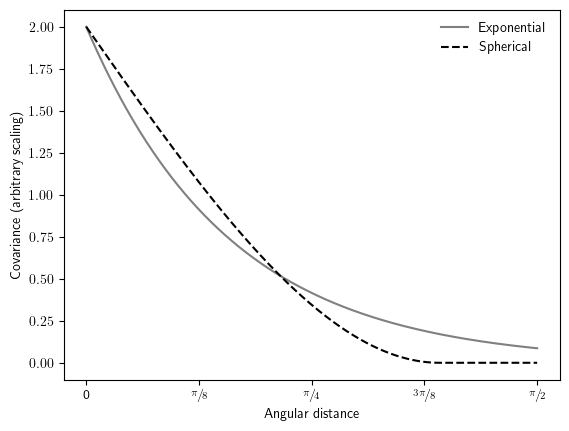

In [2]:
# Generate x-axis
theta_lin = np.linspace(0, np.pi / 2, num=1000)

# Calculate covariance functions
cov_exp = exponential_covariance(theta_lin, PARAMETER_EXPONENTIAL_a)
cov_sph = spherical_covariance(theta_lin, PARAMETER_SPHERICAL_a)

# Plot the exponential and spherical model covariances
plt.plot(theta_lin, cov_exp * PARAMETER_lambda, "gray", label="Exponential")
plt.plot(theta_lin, cov_sph * PARAMETER_lambda, "k--", label="Spherical")

plt.xticks(
    [0.0, np.pi / 8, np.pi / 4, 3 * np.pi / 8, np.pi / 2],
    ["0", r"$\sfrac{\pi}{8}$", r"$\sfrac{\pi}{4}$", r"$\sfrac{3\pi}{8}$", r"$\sfrac{\pi}{2}$"],
)

plt.xlabel("Angular distance")
plt.ylabel("Covariance (arbitrary scaling)")

plt.legend(frameon=False);

## Extracting empirical covariances

Plot empirical covariances of all voxels within the brain mask from one HCP subject.

In [3]:
hcpdata = np.load("hcpdata.npz")

b3000_mask = (hcpdata["bvals"] > 2500) & (hcpdata["bvals"] < 3500)
b3000_vecs = hcpdata["bvecs"][b3000_mask, ...]

In [4]:
triu_indices = np.triu_indices(b3000_mask.sum())

# Calculate pairwise empirical thetas and extract upper triangle
thetas_emp = compute_pairwise_angles(b3000_vecs, closest_polarity=True)[triu_indices]

In [5]:
# Standardize data, calculate covariance & extract upper triangle
b3000_data = hcpdata["b3000_data"]
b3000_data -= b3000_data.mean(0)
b3000_data /= b3000_data.std(0)

# Calculate the covariance matrix.
b3000_cov = np.cov(b3000_data)
# Introduce adjustment factors to make it more similar to Andersson2015's fig. 3.

# λ = 2, and scaling factor of 2 in the "arbitrary scaling"
b3000_cov = b3000_cov * 2.0 * 2.0
# σ² = 2
b3000_cov -= np.eye(b3000_cov.shape[0]) * 2.0

# Pick upper triangle.
b3000_cov = b3000_cov[triu_indices]

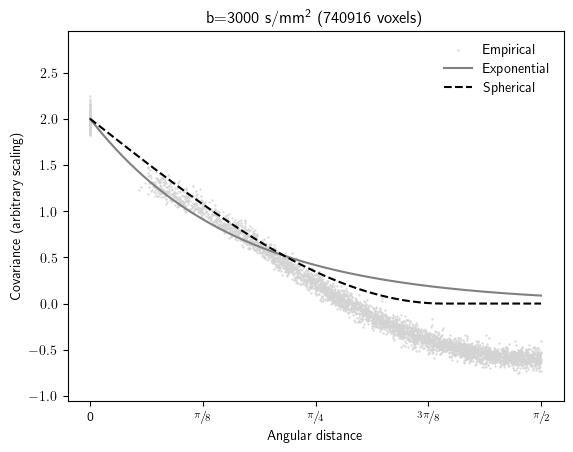

In [6]:
plt.scatter(thetas_emp, b3000_cov, s=0.3, c="lightgrey", label="Empirical")

# Plot the exponential and spherical model covariances
# Scale by a factor of 2 so that it matches Andersson2015's fig. 3.
plt.plot(theta_lin, cov_exp * PARAMETER_lambda, "gray", label="Exponential")
plt.plot(theta_lin, cov_sph * PARAMETER_lambda, "k--", label="Spherical")

plt.xticks(
    [0.0, np.pi / 8, np.pi / 4, 3 * np.pi / 8, np.pi / 2],
    ["0", r"$\sfrac{\pi}{8}$", r"$\sfrac{\pi}{4}$", r"$\sfrac{3\pi}{8}$", r"$\sfrac{\pi}{2}$"],
)

plt.xlabel("Angular distance")
plt.ylabel("Covariance (arbitrary scaling)")
plt.ylim(-1.05, 2.95)

plt.title(" ".join(("b=3000 s/mm$^\\text{2}$", f"({b3000_data.shape[1]} voxels)")))
plt.legend(frameon=False)
plt.savefig("covariance-plot.png", dpi=300, transparent=False, bbox_inches="tight");

## Checking the covariance of our simulated voxels

It seems our simulated voxels are too ideal.

In [7]:
from eddymotion.testing.simulations import simulate_voxels

NUM_VOXELS = 3000
BVAL_SHELL = 3000

data, gtab = simulate_voxels(
    S0=1000,
    evals=(0.0015, 0.0003, 0.0003),
    hsph_dirs=60,
    bval_shell=BVAL_SHELL,
    snr=8,
    n_voxels=NUM_VOXELS,
    seed=None,
)
X = gtab[~gtab.b0s_mask].bvecs
y = data[:, ~gtab.b0s_mask].T

triu_indices = np.triu_indices((~gtab.b0s_mask).sum())

# Calculate pairwise empirical thetas and extract upper triangle
synth_theta = compute_pairwise_angles(X, closest_polarity=True)[triu_indices]

# Calculate the covariance matrix and pick upper triangle.
y -= y.mean()
y /= y.std()
synth_cov = np.cov(y)[triu_indices]

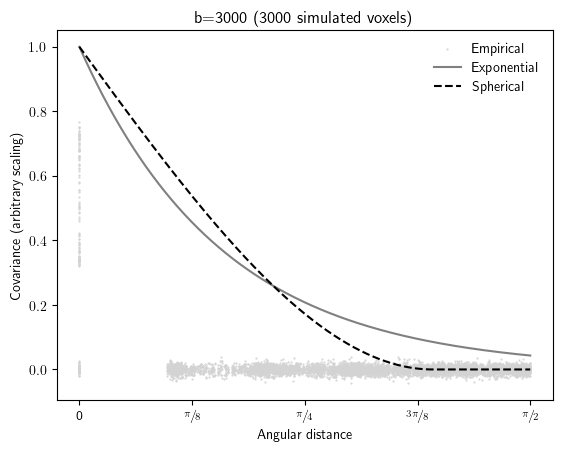

In [8]:
plt.scatter(synth_theta, synth_cov, s=0.3, c="lightgrey", label="Empirical")

# Plot the exponential and spherical model covariances
# Scale by a factor of 2 so that it matches Andersson2015's fig. 3.
plt.plot(theta_lin, cov_exp, "gray", label="Exponential")
plt.plot(theta_lin, cov_sph, "k--", label="Spherical")

plt.xticks(
    [0.0, np.pi / 8, np.pi / 4, 3 * np.pi / 8, np.pi / 2],
    ["0", r"$\sfrac{\pi}{8}$", r"$\sfrac{\pi}{4}$", r"$\sfrac{3\pi}{8}$", r"$\sfrac{\pi}{2}$"],
)

plt.xlabel("Angular distance")
plt.ylabel("Covariance (arbitrary scaling)")

plt.title(f"b={BVAL_SHELL} ({y.shape[1]} simulated voxels)")
plt.legend(frameon=False)
plt.savefig("synthetic-covariance-plot.png", dpi=300, transparent=False, bbox_inches="tight");

## Modeling the HCP data

In [9]:
from eddymotion.model._sklearn import EddyMotionGPR, SphericalKriging

X = b3000_vecs
triu_indices = np.triu_indices(b3000_mask.sum())

y_real = hcpdata["b3000_data"]
y_real -= y_real.mean(0)
y_real /= y_real.std(0)

# Calculate the covariance matrix.
y_cov = np.cov(y_real)
y_cov[np.isnan(y_cov)] = 0


y_cov -= y_cov.min()
y_cov /= y_cov.max()

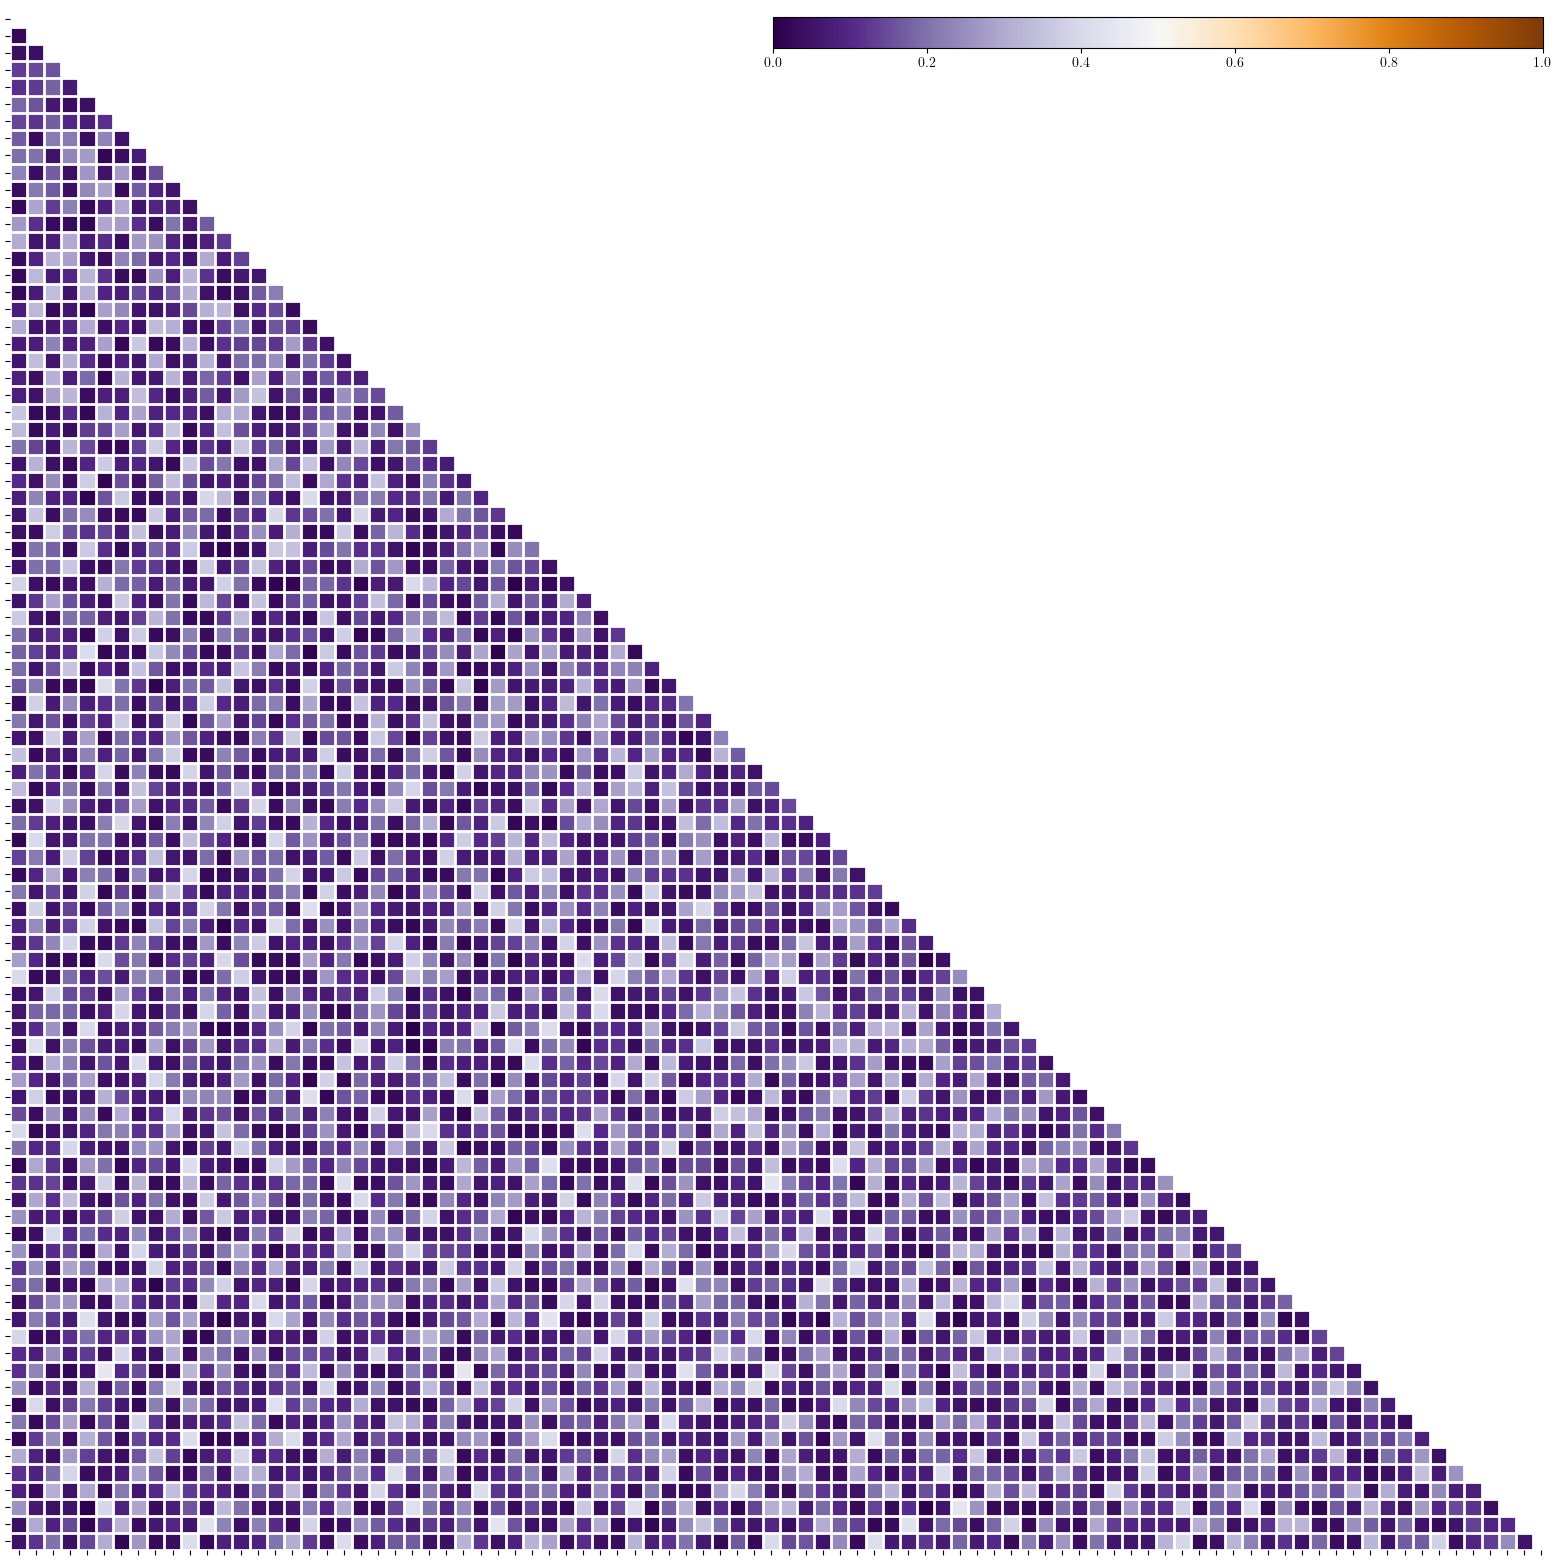

In [24]:
from mriqc_learn.viz.metrics import plot_corrmat

plot_corrmat(y_cov.copy(), col_labels=[], figsize=(20, 20), vmin=y_cov.min(), vmax=1.0);

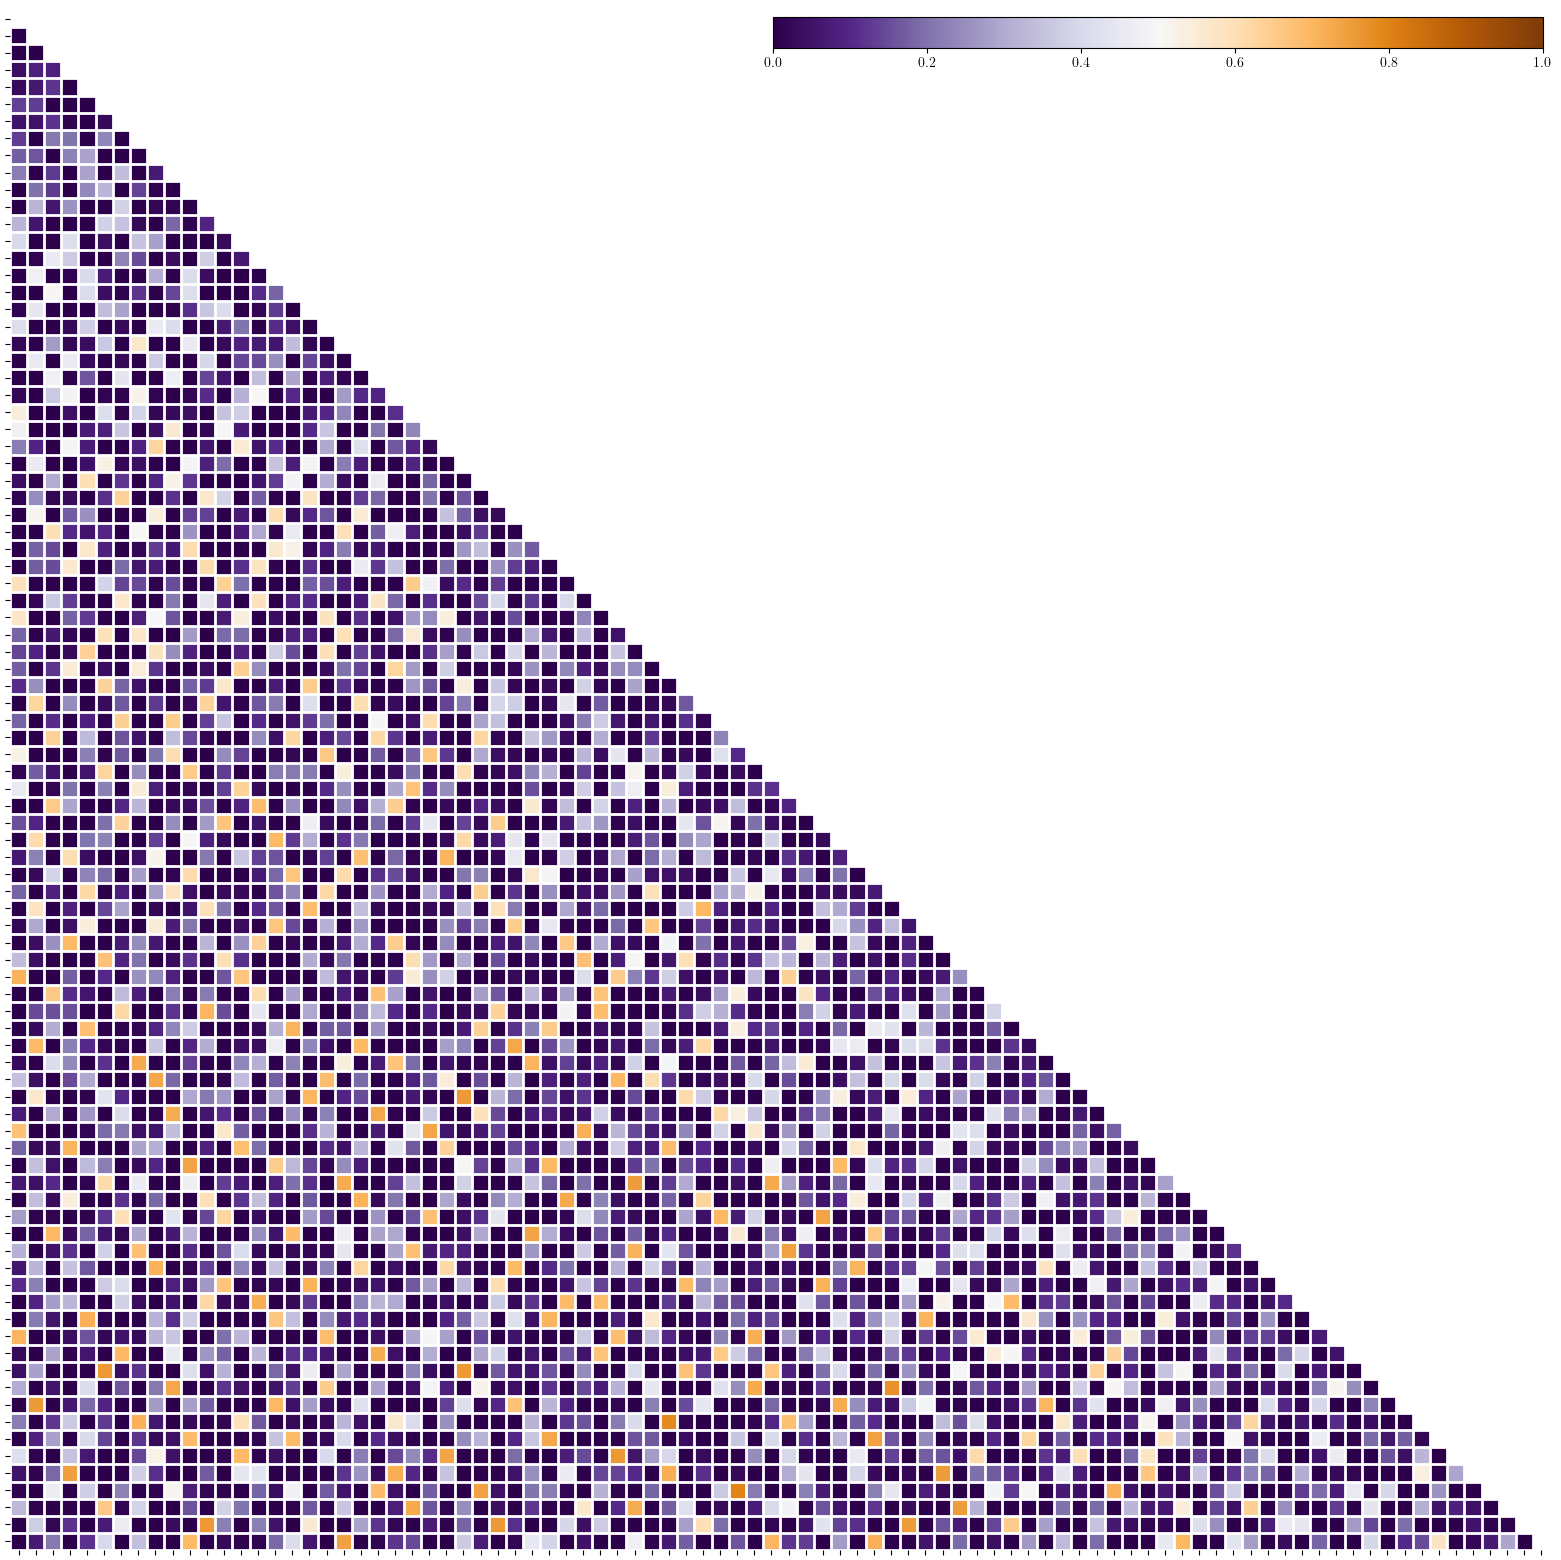

In [25]:
K = SphericalKriging(beta_a=1.23, beta_l=100)(X)
K -= K.min()
K /= K.max()
plot_corrmat(K.copy(), col_labels=[], figsize=(20, 20), vmin=K.min(), vmax=1);

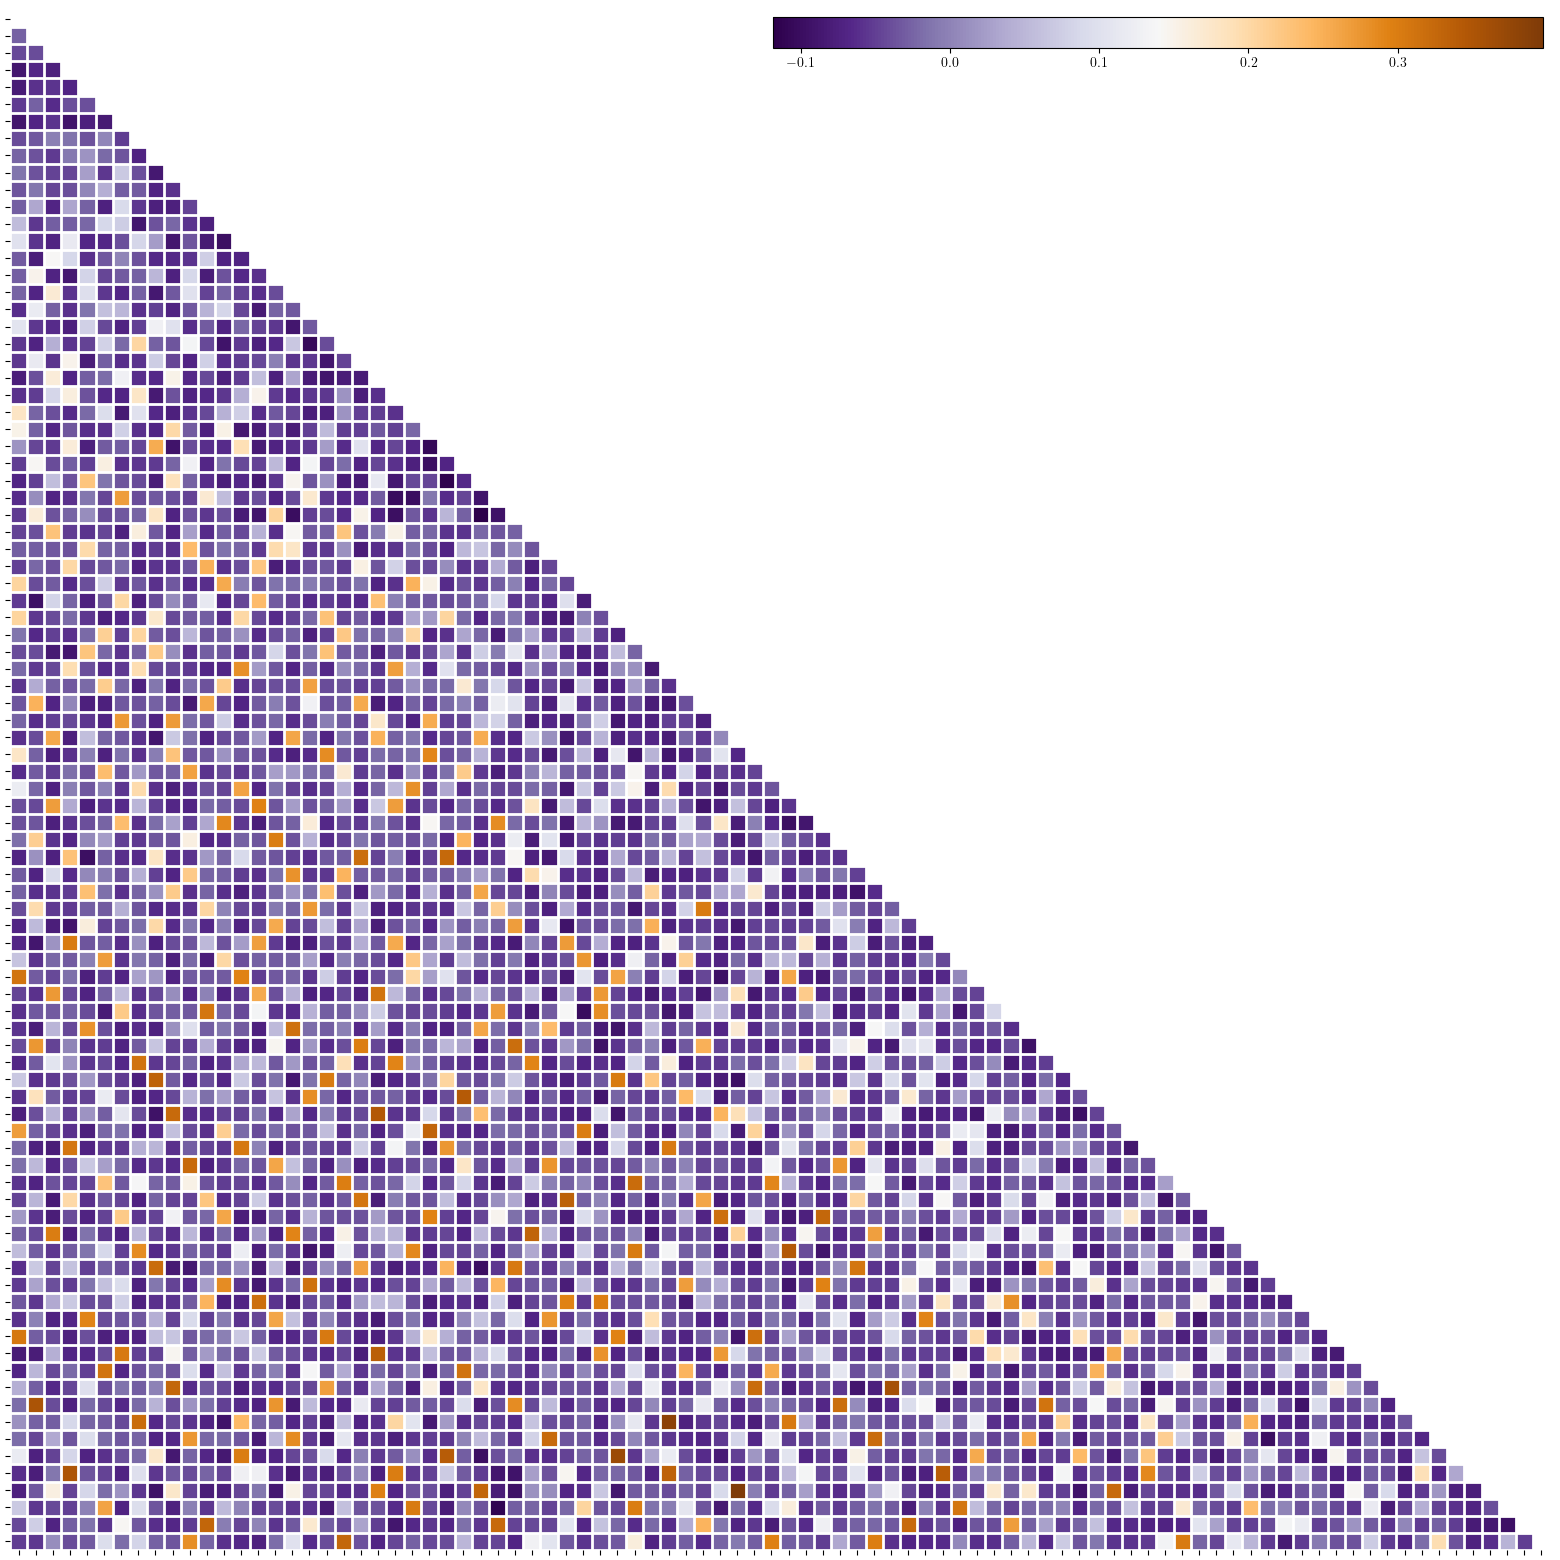

In [26]:
diff = K - y_cov
plot_corrmat(diff.copy(), col_labels=[], figsize=(20, 20), vmin=diff.min(), vmax=diff.max());

In [12]:
gpm = EddyMotionGPR(
    kernel=SphericalKriging(beta_a=1.23, beta_l=100),
    alpha=100,
    disp=True,
    optimizer="CG",
    ftol=10,
    gtol=0.1,
    # max_iter=2e5,
)

In [13]:
fitted = gpm.fit(X, y_real)

/data/home/oesteban/workspace/eddymotion/src/eddymotion/model/_sklearn.py:229: RuntimeWarning: Method CG cannot handle bounds.
  opt_res = optimize.minimize(
/home/oesteban/.miniconda/envs/eddymotion/lib/python3.11/site-packages/scipy/optimize/_minimize.py:724: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 216678690.707724
         Iterations: 2
         Function evaluations: 97
         Gradient evaluations: 85


In [14]:
fitted.kernel_

SphericalKriging (a=497485.98340783274, λ=67.26456845200116)